# **Prepare Data**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f509fbbc-148a-8d8b-8df7-5ee7f1a48a52)


In [ ]:
#------------------------------Import Libraries------------------------------
import cv2
import numpy as np 
import os
import glob
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.models import model_from_json
from keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import pickle
import time
from datetime import timedelta

In [ ]:
#------------------------------Mount Drive------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#------------------------------Start Monitoring------------------------------
from urllib.request import urlopen
exec(urlopen("http://colab-monitor.smankusors.com/track.py").read())
_colabMonitor = ColabMonitor().start()
# _colabMonitor = ColabMonitor(tpu=tpu).start()

In [ ]:
#------------------------------Check Path------------------------------
data_path = "/content/drive/MyDrive/deep learning/project/data/augmented/"
result_path = "/content/drive/MyDrive/deep learning/project/result5/"
!ls "/content/drive/MyDrive/deep learning/project/data/augmented"

nir_test.pkl   test	 test_data.pkl	 train	    train_data.pkl
nir_train.pkl  test.csv  test_label.pkl  train.csv  train_label.pkl


In [ ]:
#------------------------------Load Train Data------------------------------
start_time = time.monotonic()
with open(data_path + 'train_data.pkl', 'rb') as pickle_file:
    train_data = pickle.load(pickle_file)

with open(data_path + 'train_label.pkl', 'rb') as pickle_file:
    train_label = pickle.load(pickle_file)

with open(data_path + 'nir_train.pkl', 'rb') as pickle_file:
    nir_train = pickle.load(pickle_file)

nir_train = np.expand_dims(nir_train, axis=-1)
end_time = time.monotonic()
print('train data loaded:')
print('\telapsed time: ', timedelta(seconds=end_time - start_time))
print('\tshapes: {}, {}, {}'.format(train_data.shape, train_label.shape, nir_train.shape))
print('\ttypes:  {}, {}, {}'.format(train_data.dtype, train_label.dtype, nir_train.dtype))
print('\tmemory: {}, {}, {} MB'.format(train_data.nbytes / 1048576, train_label.nbytes / 1048576, nir_train.nbytes / 1048576))

train data loaded:
	elapsed time:  0:01:39.143847
	shapes: (3012, 512, 512, 3), (3012, 512, 512, 2), (3012, 512, 512, 1)
	types:  uint8, uint8, uint8
	memory: 2259.0, 1506.0, 753.0 MB


In [ ]:
#------------------------------Prepare Train Data------------------------------
train_data = np.concatenate((train_data, nir_train), axis=-1)

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_label[:, :, :, 1:], test_size=0.1, random_state=0)
del train_data, train_label, nir_train

Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')
print('test & train prepared:')
print('\tshapes: ', X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
print('\tdtypes: ', X_train.dtype, X_val.dtype, Y_train.dtype, Y_val.dtype)
print('\tmemory(MB): ', np.array([X_train.nbytes, X_val.nbytes, Y_train.nbytes, Y_val.nbytes]) / 1048576)
print('\tgt classes: ', np.unique(Y_val))

test & train prepared:
	shapes:  (2710, 512, 512, 4) (302, 512, 512, 4) (2710, 512, 512, 1) (302, 512, 512, 1)
	dtypes:  uint8 uint8 float32 float32
	memory(MB):  [2710.  302. 2710.  302.]
	gt classes:  [0. 1.]


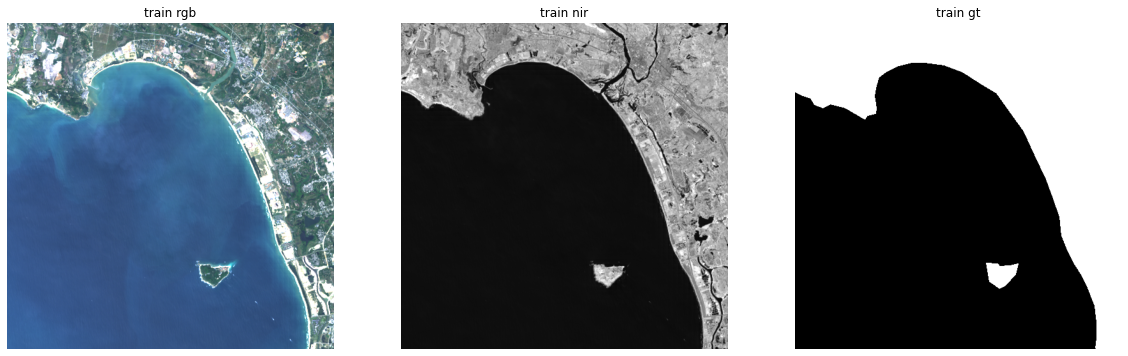

In [ ]:
#------------------------------Sanity Check------------------------------
num1, num2 = np.random.randint(len(X_train)), np.random.randint(len(X_val))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax[0].imshow(X_train[num1, :, :, :3])
ax[0].axis('off')
ax[0].set_title('train rgb')
ax[1].imshow(X_train[num1, :, :, -1], cmap='gray')
ax[1].axis('off')
ax[1].set_title('train nir')
ax[2].imshow(Y_train[num1, :, :, 0], cmap='gray')
ax[2].axis('off')
ax[2].set_title('train gt')
plt.show()

# **Build Model**

In [ ]:
#------------------------------Jaccard Loss Function------------------------------
def jaccard_coef(y_true, p_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(p_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
  return intersection / (union + 1e-6)

def jaccard_coef_loss(y_true, p_pred):
  return -jaccard_coef(y_true, p_pred)

In [ ]:
#------------------------------Design Model------------------------------
def conv_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)
    return x

def encoder_block(input_tensor, n_filters):
  x = conv_block(input_tensor, n_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input_tensor, skip_features, n_filters):
  x = Conv2DTranspose(n_filters, (2, 2), strides=2, padding="same")(input_tensor)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, n_filters)
  return x

def build_unet(input_shape, in_n_filters):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, in_n_filters*(2**0))
  s2, p2 = encoder_block(p1, in_n_filters*(2**1))
  s3, p3 = encoder_block(p2, in_n_filters*(2**2))
  s4, p4 = encoder_block(p3, in_n_filters*(2**3))

  b1 = conv_block(p4, in_n_filters*(2**4))

  d1 = decoder_block(b1, s4, in_n_filters*(2**3))
  d2 = decoder_block(d1, s3, in_n_filters*(2**2))
  d3 = decoder_block(d2, s2, in_n_filters*(2**1))
  d4 = decoder_block(d3, s1, in_n_filters*(2**0))
  d4 = Dropout(0.5)(d4)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

  model = Model(inputs, outputs, name="U-Net")
  return model

# img_h = X_train.shape[1]
# img_w = X_train.shape[2]
# n_bands = X_train.shape[3]
input_shape = (512, 512, 4)

model = build_unet(input_shape, in_n_filters=32)
model.summary()

model.compile(optimizer=Adam(learning_rate = 1e-3), loss=[jaccard_coef_loss], metrics=[jaccard_coef])

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

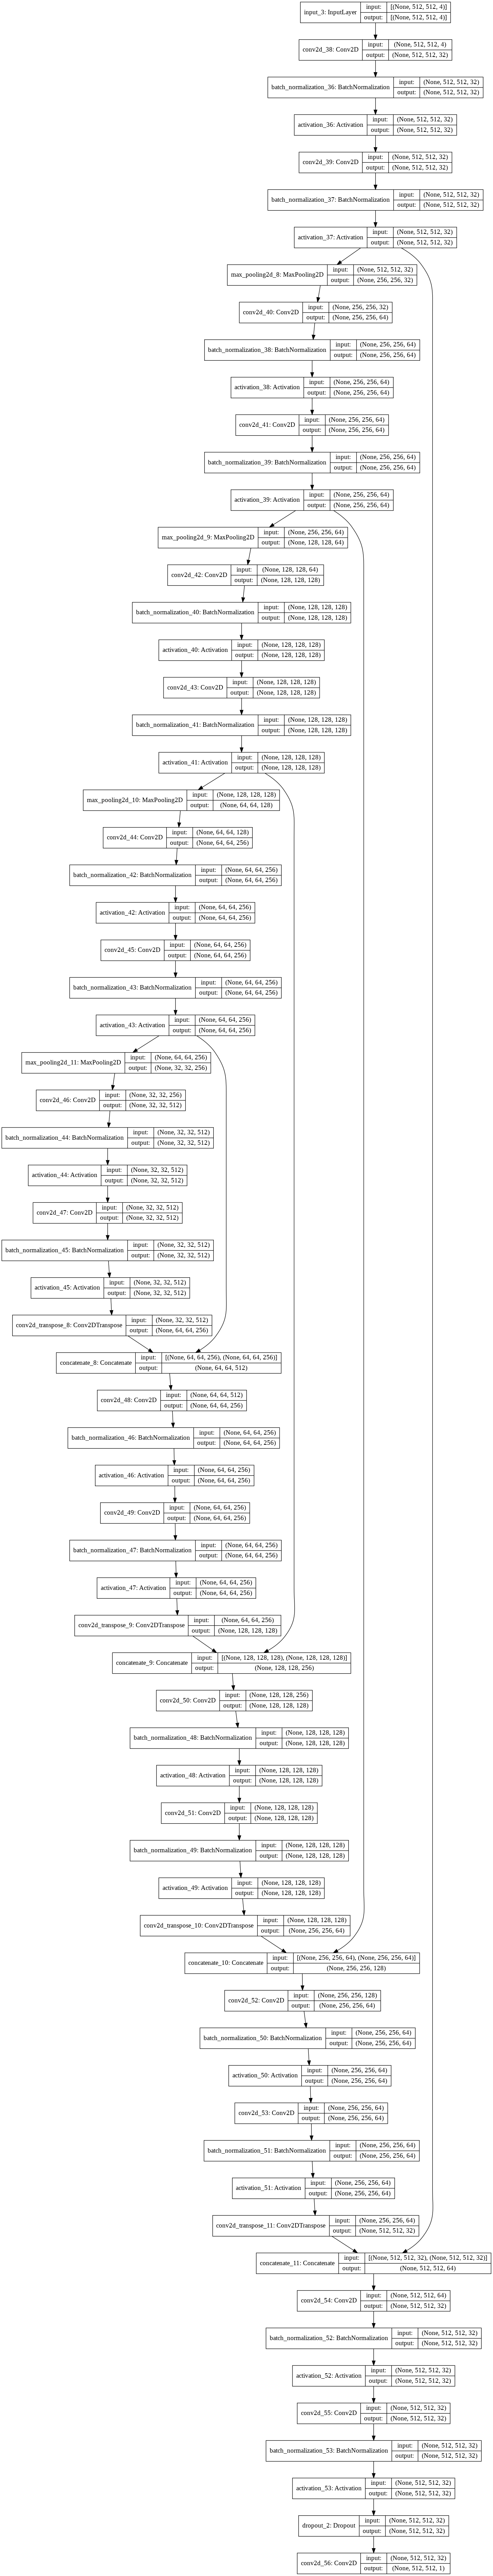

In [ ]:
#------------------------------save Model------------------------------
model_json = model.to_json()
with open(result_path + "model_architecture.json", "w") as json_file:
    json_file.write(model_json)

plot_model(model, to_file=result_path + 'model_plot.png', show_shapes=True)

# **Train Model**

In [ ]:
#------------------------------Train Model------------------------------
model.load_weights(result_path + 'weights/model_weight_ep111_130.hdf5')
nb_epoch = 20
batch_size = 16
results = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_val, Y_val))

model.save_weights(result_path + 'weights/model_weight_ep131_150.hdf5')

with open(result_path + 'weights/model_weight_ep131_150.pkl', 'wb') as pickle_file:
    pickle.dump(results.history, pickle_file)

Epoch 1/20
170/170 [==============================] - 238s 1s/step - loss: -0.9848 - jaccard_coef: 0.9847 - val_loss: -0.9751 - val_jaccard_coef: 0.9751
Epoch 2/20
170/170 [==============================] - 240s 1s/step - loss: -0.9816 - jaccard_coef: 0.9816 - val_loss: -0.9704 - val_jaccard_coef: 0.9703
Epoch 3/20
170/170 [==============================] - 240s 1s/step - loss: -0.9844 - jaccard_coef: 0.9845 - val_loss: -0.9686 - val_jaccard_coef: 0.9686
Epoch 4/20
170/170 [==============================] - 238s 1s/step - loss: -0.9842 - jaccard_coef: 0.9842 - val_loss: -0.9724 - val_jaccard_coef: 0.9724
Epoch 5/20
170/170 [==============================] - 238s 1s/step - loss: -0.9851 - jaccard_coef: 0.9851 - val_loss: -0.9750 - val_jaccard_coef: 0.9750
Epoch 6/20
170/170 [==============================] - 240s 1s/step - loss: -0.9850 - jaccard_coef: 0.9850 - val_loss: -0.9744 - val_jaccard_coef: 0.9744
Epoch 7/20
170/170 [==============================] - 240s 1s/step - loss: -0.9852